In [19]:
import itertools

import pandas as pd
import ipyrad.analysis as ipa
import ipyparallel as ipp
import toyplot
import toyplot.png

In [20]:
%cd /home/a1645424/hpcfs/analysis/shannon/results/population-structure/structure

/scratchdata1/users/a1645424/analysis/shannon/results/population-structure/structure


In [21]:
# Accessory function for dropping samples
def drop_samples(probs: dict, pop_dict: dict) -> dict:
    for k,v in probs.items():
        if k in pop_dict.keys():
            for sample in v:
                if sample in pop_dict[k]:
                    print(f"Dropping: {sample}")
                    pop_dict[k].remove(sample)
    return pop_dict

def drop_pop(drop_list: list, pop_dict: dict) -> dict:
    for p in drop_list:
        if p in pop_dict.keys():
            print(f"Dropping: {p}")
            pop_dict.pop(p)
    return(pop_dict)

In [36]:
spec = "HST"
probs = "dropped-samples.tsv"
ign = f"{spec}-ignore.txt"
data = f"{spec}-stringent.highQ.filtered.LD50k.snps.hdf5"
popmap = f"{spec}-popmap.txt"

In [37]:
# Samples we don't want to include in the analysis
problems = pd.read_csv(
    probs,
    sep = "\t",
    comment="#",
    names = ["sample", "population"]
)
problems = dict(problems.groupby("population")["sample"].apply(list))

with open(ign) as f:
    ignore = f.read().splitlines()

In [38]:
# Burnin/nreps
burnin = 100000
numreps = 200000

# Population-map file
populations = pd.read_csv(popmap, comment="#", sep=" ", names=["sample", "grouping"])

# Convert to dictionary
imap = dict(populations.groupby("grouping")["sample"].apply(list))
imap = drop_samples(probs=problems, pop_dict=imap)
imap = drop_pop(drop_list=ignore, pop_dict=imap)

# 50% missing data per population group
minmap = {i: 0.5 for i in imap}

Dropping: HST-KLS0360-2562274
Dropping: HST-KLS0634-2892478
Dropping: HST-KLS1679-4013420
Dropping: HST-KLS1677-4013418
Dropping: HST-KLS0660-2892454
Dropping: HST-KLS0886-2892390
Dropping: HST-KLS0941-2892545
Dropping: HST-KLS0897-2892551
Dropping: HST-KLS0896-2892403
Dropping: HST-As012-3991487
Dropping: HST-As010-3991485
Dropping: HST-KLS1204-3593361
Dropping: Gulf_of_Carpentaria
Dropping: Ashmore
Dropping: North_QLD
Dropping: Heywood_Shoal


In [39]:
rerun = ipa.structure(
    data=data,
    name=f"{spec}",
    workdir="analysis-structure",
    imap=imap,
    load_only=True,
)

etable = rerun.get_evanno_table([2, 3, 4, 5, 6, 7, 8 , 9])

40 previous results loaded for run [HST]


/hpcfs/users/a1645424/micromamba/envs/ipyrad/lib/python3.10/site-packages/ipyrad/analysis/structure.py:1036: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-94.08000000000175' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tab.loc[kpop, "lnPK"] = tab.loc[kpop, "estLnProbMean"] \
/hpcfs/users/a1645424/micromamba/envs/ipyrad/lib/python3.10/site-packages/ipyrad/analysis/structure.py:1040: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '189.41999999999825' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tab.loc[kpop, "lnPPK"] = abs(tab.loc[kpop+1, "lnPK"]
/hpcfs/users/a1645424/micromamba/envs/ipyrad/lib/python3.10/site-packages/ipyrad/analysis/structure.py:1042: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas

In [40]:
etable.to_csv(f"./{spec}-etable.csv")

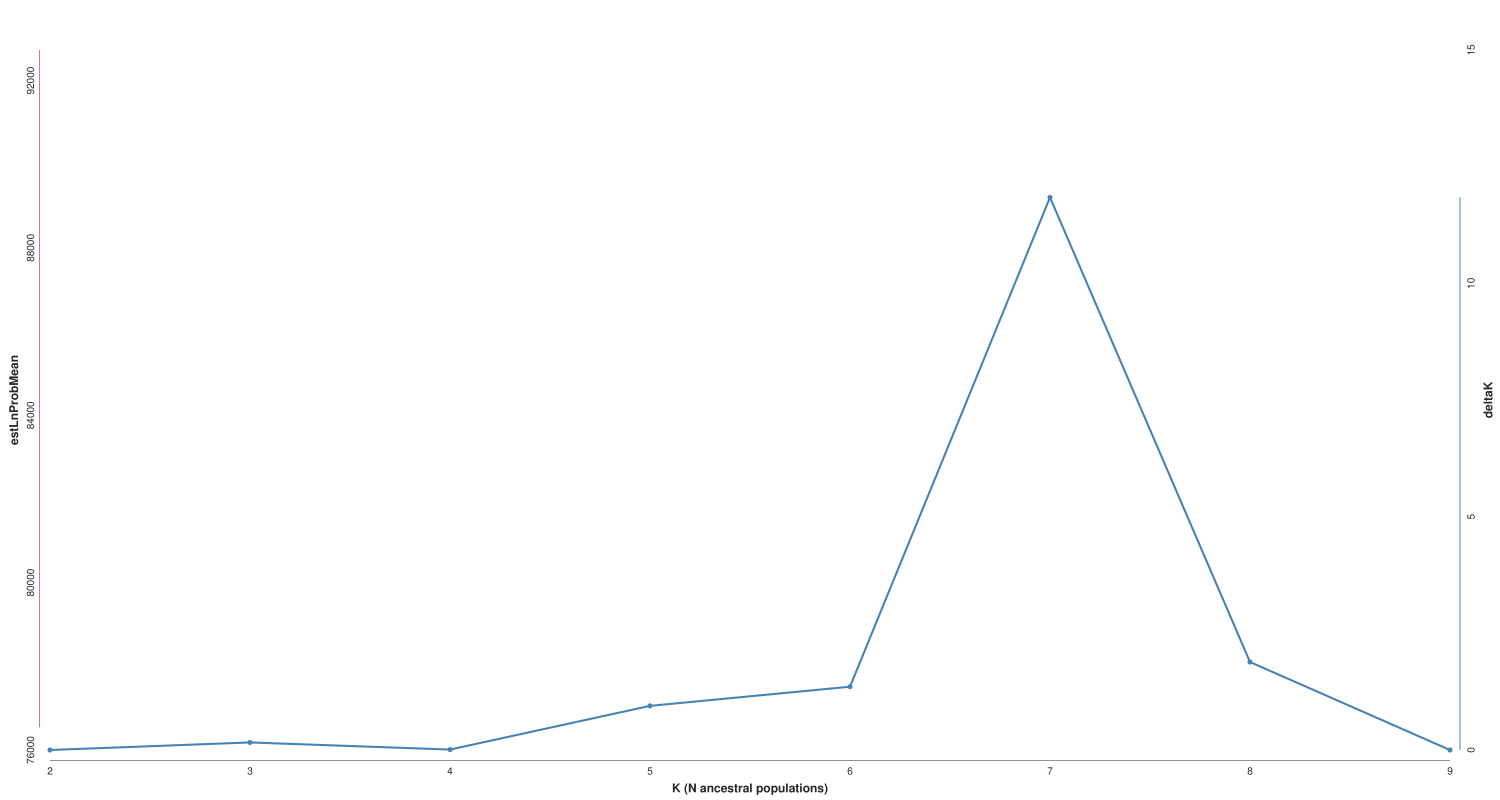

In [41]:
canvas = toyplot.Canvas(width=1500, height=800)
canvas.style.update({"background-color": "white"})

# plot the mean log probability of the models in red
axes = canvas.cartesian(ylabel="estLnProbMean")
axes.plot(etable.estLnProbMean * -1, color="darkred", marker="o")
axes.y.spine.style = {"stroke": "darkred"}

# plot delta K with its own scale bar of left side and in blue
axes = axes.share(
    "x", ylabel="deltaK", ymax=etable.deltaK.max() + etable.deltaK.max() * 0.25
)
axes.plot(etable.deltaK, color="steelblue", marker="o")
axes.y.spine.style = {"stroke": "steelblue"}

# set x labels
axes.x.ticks.locator = toyplot.locator.Explicit(range(len(etable.index)), etable.index)
axes.x.label.text = "K (N ancestral populations)"

# Save figure
toyplot.png.render(canvas, f"{spec}-deltaK-burnin_{burnin}-numreps_{numreps}.png")
canvas

In [42]:
for i in range(2, 10):
    table = rerun.get_clumpp_table(i)

    # sort list by columns
    table.sort_values(by=list(range(i)), inplace=True)

    # or, sort by a list of names (here taken from imap)
    onames = list(itertools.chain(*imap.values()))
    table = table.loc[onames]
    table.to_csv(f"{spec}-structure-k{i}-burnin_{burnin}-numreps_{numreps}.plot.csv")

    # build barplot
    canvas = toyplot.Canvas(width=1500, height=800)
    canvas.style.update({"background-color": "white"})
    axes = canvas.cartesian(bounds=("10%", "90%", "10%", "45%"))
    axes.bars(table)

    # add labels to x-axis
    ticklabels = [i for i in table.index.tolist()]
    axes.x.ticks.locator = toyplot.locator.Explicit(labels=ticklabels)
    axes.x.ticks.labels.angle = -60
    axes.x.ticks.show = True
    axes.x.ticks.labels.offset = 10
    axes.x.ticks.labels.style = {"font-size": "12px"}

    toyplot.png.render(
        canvas, f"{spec}-structure-k{i}-burnin_{burnin}-numreps_{numreps}.png"
    )

[K2] 5/5 results permuted across replicates (max_var=0).
[K3] 5/5 results permuted across replicates (max_var=0).
[K4] 5/5 results permuted across replicates (max_var=0).
[K5] 5/5 results permuted across replicates (max_var=0).
[K6] 5/5 results permuted across replicates (max_var=0).
[K7] 5/5 results permuted across replicates (max_var=0).
[K8] 5/5 results permuted across replicates (max_var=0).
[K9] 5/5 results permuted across replicates (max_var=0).
